# LSN - simulation test code
* **Running things on compute canada (Graham)**

- Submit jobs: sbatch tf_test_job.sh

    #!/bin/bash
    #SBATCH --gres=gpu:1        # request GPU "generic resource"
    #SBATCH --cpus-per-task=6   # maximum CPU cores per GPU request: 6 on Cedar, 16 on Graham.
    #SBATCH --mem=32000M        # memory per node
    #SBATCH --account=def-mchakrav
    #SBATCH --time=0-00:05      # time (DD-HH:MM)
    #SBATCH --output=%N-%j.out  # %N for node name, %j for jobID

    module load cuda cudnn python/3.5.2
    module load scipy-stack/2018b
    source ../tensorflow/bin/activate
    python ./LSN_sim_testcode_3D.py
    
- Monitor jobs: squeue -u nikhil 
- Cancel jobs: scancel <jobid>

In [109]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import random
import time
import math
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime

# Main slim library
slim = tf.contrib.slim

# LSN Class and other functions

In [47]:
# Main slim library
slim = tf.contrib.slim

class siamese_net(object):
  
    def __init__(self, net_arch):
              
        self.MR_input = tf.placeholder(tf.float32, [None, net_arch['input'],net_arch['input'],
                                                    net_arch['input']],name='baseline')        
        self.labels = tf.placeholder(tf.float32, [None,net_arch['output']],name='trajectory')                
        self.is_training = True  #toggles dropout in slim
        self.dropout = 1      
        
        self.branch = self.convnet_slim(self.MR_input, net_arch)
        
        # Create metrics              
        self.preds = self.get_predictions(net_arch)
        self.loss = self.get_loss()
        self.accuracy = self.get_accuracy()

    # Individual branch    
    def convnet_slim(self, X, net_arch):
        with slim.arg_scope([slim.conv3d], activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(net_arch['reg'])):

            # If needed, within the scope layer is made linear by setting activation_fn=None.
            # Creates a fully connected layers 
            for l in range(net_arch['n_layers']):
                net = slim.conv3d(X, net_arch['n_filters'], net_arch['filter_size'], normalizer_fn=slim.batch_norm,
                                  scope='fc{}'.format(l))
                net = slim.dropout(net, self.dropout, is_training=self.is_training)

            # MR output
            net = slim.flatten(net, scope='flatten3')
            MR_predictions = slim.fully_connected(net, net_arch['MR_output'], 
                                                  normalizer_fn=slim.batch_norm, scope='MR_prediction')               

            return MR_predictions #Later also return end_points 
    

    def get_predictions(self, net_arch):
        penult_predict = slim.fully_connected(self.branch, net_arch['output'], activation_fn=tf.nn.softmax, 
                                               normalizer_fn=slim.batch_norm, scope='aux_prediction')
        return penult_predict

   
    # Set methods for class variables
    def set_dropout(self, dropout):
        self.dropout = dropout
      
    def set_train_mode(self,is_training):  
        self.is_training = is_training
      
    # Get methods for loss and acc metrics
    def get_loss(self):            
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,logits=self.preds)) 

    def get_accuracy(self):
        correct_preds = tf.equal(tf.argmax(self.labels,1), tf.argmax(self.preds,1))
        return tf.reduce_mean(tf.cast(correct_preds, tf.float32)) 

    
# Other helper functions
def next_batch(s,e,mr_inputs,labels):
    input1 = mr_inputs[s:e]     
    y = labels[s:e]    
    return input1,y
  
def check_data_shapes(data,net_arch):
    check = True  
    n_layers = net_arch['n_layers']
    if data['X_MR'].shape[1] != 2:
        print('wrong input data dimensions - need MR data for two branches')
        check = False
    elif data['X_MR'].shape[2] != net_arch['MR_shape']:
        print('input MR data <-> LSN arch mismatch')
        check = False
    elif data['X_aux'].shape[1] != net_arch['aux_shape']:
        print('input aux data <-> LSN arch mismatch')
        check = False
    elif data['y'].shape[1] != net_arch['output']:
        print('number of classes (2,3) <-> LSN arch mismatch')
        check = False
    else:
        for l in range(n_layers):
            try:
                _ = net_arch['l{}'.format(l+1)]
            except:
                print('Specify number of nodes for layer {}'.format(l))
                check = False        

    return check

In [31]:
# Train and test defs
def train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout, validate_after, verbose):
    valid_frac = int(0.1*len(data['y']))
    
    # Split into train and valid data for hyperparam tuning
    X_MR_train = data['X_MR'][:1-valid_frac]    
    y_train = data['y'][:1-valid_frac]

    X_MR_valid = data['X_MR'][1-valid_frac:]    
    y_valid = data['y'][1-valid_frac:]

    total_batch = int(len(y_train)/batch_size)
    #print('total_batch {}'.format(total_batch))
    
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []
    
    # Training cycle
    for epoch in range(n_epochs):
        avg_loss = 0.
        avg_acc = 0.
        start_time = time.time()
        # Loop over all batches
        for i in range(total_batch):
            s  = i * batch_size
            e = (i+1) *batch_size

            # Fit training using batch data
            MR_batch,y_batch = next_batch(s,e,X_MR_train,y_train)

            # Train pass
            lsn.set_dropout(dropout)
            _,preds,loss_value,acc_value=sess.run([optimizer,lsn.preds,lsn.loss,lsn.accuracy], 
                                        feed_dict={lsn.MR_input:MR_batch,lsn.labels:y_batch})                

            avg_loss += loss_value
            avg_acc +=acc_value*100

        duration = time.time() - start_time
        if verbose:
            print('epoch %d  time: %.2f loss %0.4f acc %0.2f' %(epoch,duration,avg_loss/total_batch,avg_acc/total_batch))      

        #Compute perf on entire training and validation sets (no need after every epoch)
        if epoch%validate_after == 0:
            train_acc = lsn.accuracy.eval(feed_dict={lsn.MR_input:X_MR_train, lsn.labels:y_train})
            valid_acc = lsn.accuracy.eval(feed_dict={lsn.MR_input:X_MR_valid, lsn.labels:y_valid})
            train_loss = lsn.loss.eval(feed_dict={lsn.MR_input:X_MR_train, lsn.labels:y_train})
            valid_loss = lsn.loss.eval(feed_dict={lsn.MR_input:X_MR_valid, lsn.labels:y_valid})
            print('performance on entire train and valid subsets')
            print('epoch {}\t train_acc:{}\t valid_acc:{}\n'.format(epoch,train_acc,valid_acc))
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
  
    # Post training: Compute preds and metrics for entire train data
    X_MR_train = data['X_MR']    
    y_train = data['y']
    train_feature = lsn.branch.eval(feed_dict={lsn.MR_input:X_MR_train})    
    train_preds= lsn.preds.eval(feed_dict={lsn.MR_input:X_MR_train})

    train_metrics = {'train_feature':train_feature,'train_preds':train_preds,
                     'train_loss':train_loss_list,'train_acc':train_acc_list,
                     'valid_loss':valid_loss_list,'valid_acc':valid_acc_list}

    return lsn, train_metrics

def test_lsn(sess,lsn,data):
    print('Testing model')    
    lsn.set_dropout(1)
    lsn.set_train_mode(False) 
    X_MR_test = data['X_MR']    
    y_test = data['y']
    #print(lsn.dropout)

    test_feature = lsn.branch.eval(feed_dict={lsn.MR_input:X_MR_test})    

    test_preds = lsn.preds.eval(feed_dict={lsn.MR_input:X_MR_test})
    test_acc = lsn.accuracy.eval(feed_dict={lsn.MR_input:X_MR_test, lsn.labels:y_test})

    test_metrics = {'test_feature':test_feature,'test_preds':test_preds,'test_acc':test_acc}
    print('Accuracy test set %0.2f' % (100 * test_acc))
    return lsn, test_metrics


# Generate simulation data 

In [ ]:
sampx = 1000
classes = 2
MR_size = 10

# Simple random numbers with modulated mean
X_MR = np.random.rand(classes*sampx,MR_size,MR_size,MR_size)
y_cat = np.ones(sampx*classes)

# Modify feature distributions
for i in range(classes):
    X_MR[i*sampx:(i+1)*sampx] = X_MR[i*sampx:(i+1)*sampx]/(i+1)
    print('mean of i\'th subset {:4.2}'.format(np.mean(X_MR[i*sampx:(i+1)*sampx])))
    y_cat[i*sampx:(i+1)*sampx] = y_cat[i*sampx:(i+1)*sampx]*i

# Spatially varying boxes
* **Two possible variations**
    1. amplitude of the signal (i.e. box_signal)
    2. location of the signal (i.e. box offset)

In [221]:

from random import randint


sampx = 2000
classes = 2
MR_size = 10

# no-noise
#X_MR = np.zeros((classes*sampx,MR_size,MR_size,MR_size))

# Gaussian noise
mu,st_dev = 0,1
X_MR = st_dev * np.random.randn(classes*sampx,MR_size,MR_size,MR_size) + mu

box_size = 5
box_signal = 2
offset = MR_size - box_size
offset_modulator = 0.75
signal_modulator = 1

X_box = box_signal*np.ones((box_size,box_size,box_size))
for s in range(sampx):
    a,b,c = randint(0,offset),randint(0,offset),randint(0,offset)
    X_MR[s,a:a+box_size,b:b+box_size,c:c+box_size] = X_box
    
X_box = signal_modulator*box_signal*np.ones((box_size,box_size,box_size))
for s in range(sampx,2*sampx):
    a,b,c = int(offset_modulator*randint(0,offset)),int(offset_modulator*randint(0,offset)),int(offset_modulator*randint(0,offset))
    X_MR[s,a:a+box_size,b:b+box_size,c:c+box_size] = X_box

print('box mean {}, class_0 mean {}, class_1 mean {}'.format(np.mean(X_box),np.mean(X_MR[:sampx]),np.mean(X_MR[sampx:2*sampx])))

box mean 2.0, class_0 mean 0.2518962281188369, class_1 mean 0.2500777422559805


In [222]:
# Produce one-hot labels
if classes > 2:
    lb = LabelBinarizer()
    y = lb.fit_transform(y_cat)
else:
    y = np.zeros((sampx*classes,2))
    y[:sampx,1]=np.ones(sampx)
    y[sampx:2*sampx,0]=np.ones(sampx)
    
# Shuffle data before train-test split
indx_shuff = np.arange(classes*sampx)
np.random.shuffle(indx_shuff)
X_MR = np.squeeze(X_MR[indx_shuff])
y = np.squeeze(y[indx_shuff])

# Train-test splits
train_frac = int(0.9*(classes*sampx))
X_MR_train = X_MR[:train_frac]
y_train = y[:train_frac]

X_MR_test = X_MR[train_frac:]
y_test = y[train_frac:]
subject_idx_test = indx_shuff[train_frac:]

print('shapes of X_MR_train:{}, y_train:{}, \n\t X_MR_test:{}, y_test:{}'.format(X_MR_train.shape,y_train.shape,
                                                                                 X_MR_test.shape,y_test.shape)) 

shapes of X_MR_train:(3600, 10, 10, 10), y_train:(3600, 2), 
	 X_MR_test:(400, 10, 10, 10), y_test:(400, 2)


# Train and test a sample LSN

In [223]:
# training params
lr = 0.0001
n_epochs = 200
validate_after = 10
batch_size = 100
dropout = 0.8 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 
save_model = True
save_model_path = '/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/TF_trained_models/'

net_arch = {'input':MR_size,'n_filters':5,'filter_size':3,'n_layers':10,'MR_output':10,
            'output':classes,'reg':0.1}

# minimal perf df --> append CV related attributes downstream. 
perf_df = pd.DataFrame(columns=['subject_id','label','pred_prob','pred_label'])

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
    # Train model    
    data = {'X_MR':X_MR_train,'y':y_train}    
    if True: #check_data_shapes(data,net_arch):      
        print('train data <-> net_arch check passed')   
        lsn = siamese_net(net_arch)                
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
        tf.global_variables_initializer().run()
        saver = tf.train.Saver()

        cur_time = datetime.time(datetime.now())
        print('\nStart training time: {}'.format(cur_time))                
        lsn, train_metrics = train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout,
                                       validate_after,verbose)
        
        #Save trained model
        if save_model:
            print('saving model at {}'.format(save_model_path + 'lsn_example'))
            saver.save(sess, save_model_path + 'lsn_example')
        
        cur_time = datetime.time(datetime.now())
        print('End training time: {}\n'.format(cur_time))  
      
    else:
        print('train data <-> net_arch check failed')

    # Test model      
    data = {'X_MR':X_MR_test,'y':y_test}
    if True: #check_data_shapes(data,net_arch):
        print('test data <-> net_arch check passed')   
        _,test_metrics = test_lsn(sess,lsn,data)        
        # populate perf dataframe
        perf_df['subject_id']  = subject_idx_test
        perf_df['label'] = np.argmax(y_test,1)
        perf_df['pred_prob'] = list(test_metrics['test_preds'])
        perf_df['pred_label'] = np.argmax(test_metrics['test_preds'],1)
    else:
        print('test data <-> net_arch check failed')   


train data <-> net_arch check passed

Start training time: 13:01:33.683838
performance on entire train and valid subsets
epoch 0	 train_acc:0.5671089291572571	 valid_acc:0.5766016840934753

performance on entire train and valid subsets
epoch 10	 train_acc:0.7661215662956238	 valid_acc:0.7688022255897522

performance on entire train and valid subsets
epoch 20	 train_acc:0.8318420052528381	 valid_acc:0.8300835490226746

performance on entire train and valid subsets
epoch 30	 train_acc:0.849429190158844	 valid_acc:0.8495821952819824

performance on entire train and valid subsets
epoch 40	 train_acc:0.8571428656578064	 valid_acc:0.8579387068748474

performance on entire train and valid subsets
epoch 50	 train_acc:0.8623881340026855	 valid_acc:0.8467966318130493

performance on entire train and valid subsets
epoch 60	 train_acc:0.8697932958602905	 valid_acc:0.844011127948761

performance on entire train and valid subsets
epoch 70	 train_acc:0.8796667456626892	 valid_acc:0.8384401202201843



# Restore dave TF session with pretrained model

In [10]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(save_model_path + 'lsn_example.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
    _,test_metrics = test_lsn(sess,lsn,data) 
    

INFO:tensorflow:Restoring parameters from /data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/TF_trained_models/lsn_example
Testing model
Accuracy test set 99.20


In [72]:
#sns.distplot(perf_df['label'].values)

# Plots

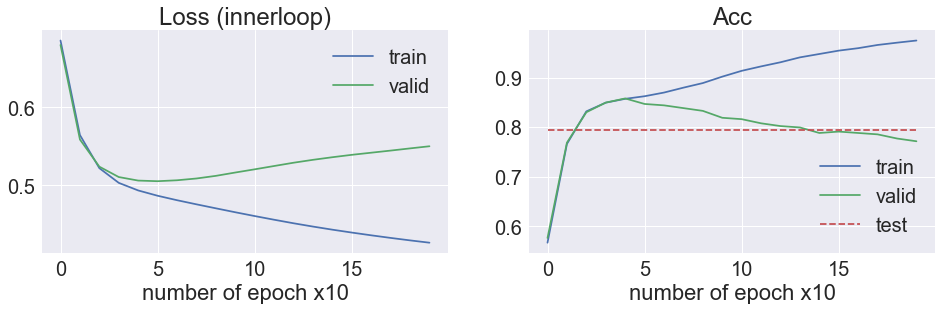

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

plt.figure(figsize=(16,9))
plt.style.use('seaborn-white')
sns.set(font_scale=2)
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
train_acc = train_metrics['train_acc']
valid_acc = train_metrics['valid_acc']

plt.subplot(2,2,1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.title('Loss (innerloop)')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_acc,label='train');
plt.plot(valid_acc,label='valid');
plt.plot(np.tile(test_metrics['test_acc'],len(train_acc)),'--',label='test')
plt.title('Acc')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

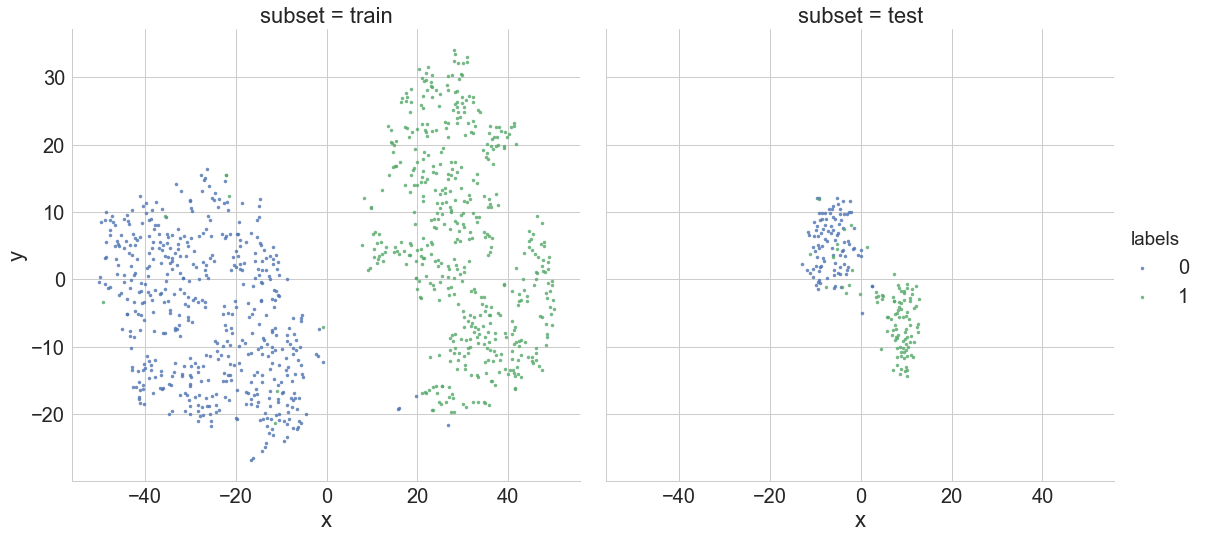

In [215]:
#Plot TSNE
tsne_sampx = 1000 #Too slow for large number of samples
train_embed = train_metrics['train_feature']
test_embed = test_metrics['test_feature']


train_tsne_embed = TSNE(n_components=2,init='pca').fit_transform(train_embed[:tsne_sampx])
test_tsne_embed = TSNE(n_components=2,init='pca').fit_transform(test_embed[:tsne_sampx])

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])

train_df['x'] = train_tsne_embed[:,0] 
train_df['y'] = train_tsne_embed[:,1] 
train_df['labels'] = np.argmax(y_train[:tsne_sampx],1)
train_df['subset'] = np.tile('train',len(y_train[:tsne_sampx]))

test_df['x'] = test_tsne_embed[:,0] 
test_df['y'] = test_tsne_embed[:,1] 
test_df['labels'] = np.argmax(y_test[:tsne_sampx],1)
test_df['subset'] = np.tile('test',len(y_test[:tsne_sampx]))

plot_df = train_df.append(test_df)
with sns.axes_style("whitegrid"):
    sns.lmplot(x='x',y='y',hue='labels',col='subset',col_wrap=2, 
               fit_reg=False, markers='.',data=plot_df,size=8);

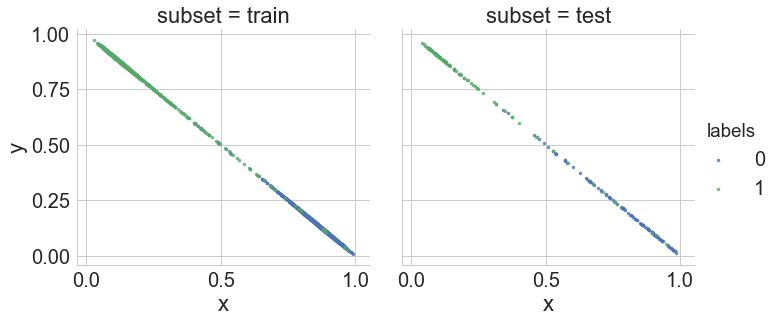

In [216]:
# Plot preds
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = np.argmax(y_train,1)
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = np.argmax(y_test,1)
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
with sns.axes_style("whitegrid"):
    sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);


In [107]:
# Tmp delete after reading csv
baseline_dir = '/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/'
clinical_scale = 'MMSE'
cohort = 'ALL_ADNI'
exp_name = 'Exp_502_{}_traj_{}_tp_var_tp'.format(cohort,clinical_scale)
exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'
exp_setup = pd.read_pickle(exp_setup_path)
df = exp_setup['df']
print('exp_name: {}, number of subjects:{}'.format(exp_name,len(set(df['PTID'].values))))
print('label counts: 0:{}, 1:{}'.format(len(df[df['traj']==0]),len(df[df['traj']==1])))
df.columns


exp_name: Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp, number of subjects:1116
label counts: 0:674, 1:442


Index(['Unnamed: 0', 'PTID', 'AGE', 'APOE4', 'PTGENDER', 'DX_bl',
       'PreCG.L_CT_bl', 'PreCG.R_CT_bl', 'SFGdor.L_CT_bl', 'SFGdor.R_CT_bl',
       ...
       'TPOsup.R_CT_rate', 'MTG.L_CT_rate', 'MTG.R_CT_rate',
       'TPOmid.L_CT_rate', 'TPOmid.R_CT_rate', 'ITG.L_CT_rate',
       'ITG.R_CT_rate', 'traj', 'ORIGPROT', 'strata'],
      dtype='object', length=248)

In [108]:
# G_df = df[['PTID','traj','AGE','APOE4','PTGENDER','DX_bl','ORIGPROT']]
# G_df.to_csv('/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/adni_traj_demograph.csv')